<a href="https://colab.research.google.com/github/GusSand/dl-demos/blob/main/demo03-optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization in Deep Learning

Goal of this tutorial: Visualize the effect of different optimizers used in deep learning

- Gradient descent
- Newton's method
- Momentum
- ADAM

h/t: [CMU 11-785](http://deeplearning.cs.cmu.edu/S21/document/recitation/Recitation3_IDL_S21.ipynb) and this fantastic [Distill.pub](https://distill.pub/2017/momentum/) article.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

init = torch.tensor([-5.0,7.5])

class QuadFunc:
    # f(x,y) = a x^2 + b y^2 + c x y + d x + e y
    def __init__(self,a,b,c,d,e):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e

    def getParams(self,x,y):
        if y is None:
            y = x[1]
            x = x[0]
        return x, y

    def __call__(self,x,y=None):
        x,y = self.getParams(x,y)
        return 0.5*(self.a*x**2 + self.b*y**2 + 2*self.c*x*y) + self.d*x + self.e*y

    def grad(self,x,y=None):
    # d f(x,y)/ dx = a x + c y + d
    # d (fx,y)/ dy = b y + c x + e
        x,y = self.getParams(x,y)
        return torch.tensor([self.a*x+self.c*y+self.d,self.b*y+self.c*x+self.e])

    def hess(self,x,y=None):
    # d^2 f(x,y)/ dx^2 = a
    # d^2 f(x,y)/ dy^2 = b
    # d^2 f(x,y)/ dydx = c
        x,y = self.getParams(x,y)
        return torch.tensor([[self.a,self.c],[self.c,self.b]])

class GradientDescent:
    # Algorithm from here: https://arxiv.org/abs/1412.6980

    def __init__(self,lr=1,b1=0.9,b2=0.999):
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param
        self.b2 = b2 # grad^2 aggregation param

        self.v = 0 # grad aggregation
        self.w = 0 # grad^2 aggregation
        self.t = 0

        self.eps = 1.0e-9

    def __call__(self,grad,hess):

        self.t += 1

        # aggregation
        self.v = self.b1*(self.v) + (1-self.b1)*grad
        self.w = self.b2*(self.w) + (1-self.b2)*grad**2

        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1

        return -self.lr*vcorr/( wcorr**0.5 + self.eps )


class Newtons:
    # https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    def __init__(self,lr=1):
        self.lr = lr

    def __call__(self,grad,hess):
        return -self.lr*torch.matmul(torch.inverse(hess),grad)

def runOptim(init,optim,func,steps):

    curpos = init # current position
    path = [curpos]


    for _ in range(steps):

        grad = func.grad(curpos)
        hess = func.hess(curpos)

        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)

    return path

def showPath(func,init,paths,labels,colors, levels):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)

    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)

    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz,cmap=cm.gray)
    fig.colorbar(cp)

    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')

    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')

    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)

We will try to visualize running gradient descent (and its variants) on a simple quadratic function in two variables:
$$f(x,y) = ax^2 + by^2 + cxy + dx + ey $$

By setting the constants differently, the above function represents all conic surfaces -- paraboloids, hyperboloids, ellipsoids, etc. Let's see how to optimize these functions.

# Regular gradient descent

Let's start with a simple parabolic function: $f(x,y) = x^2 + y^2$. Here, the function is convex, the "valley" has a unique global minimum, and optimization is straightforward.

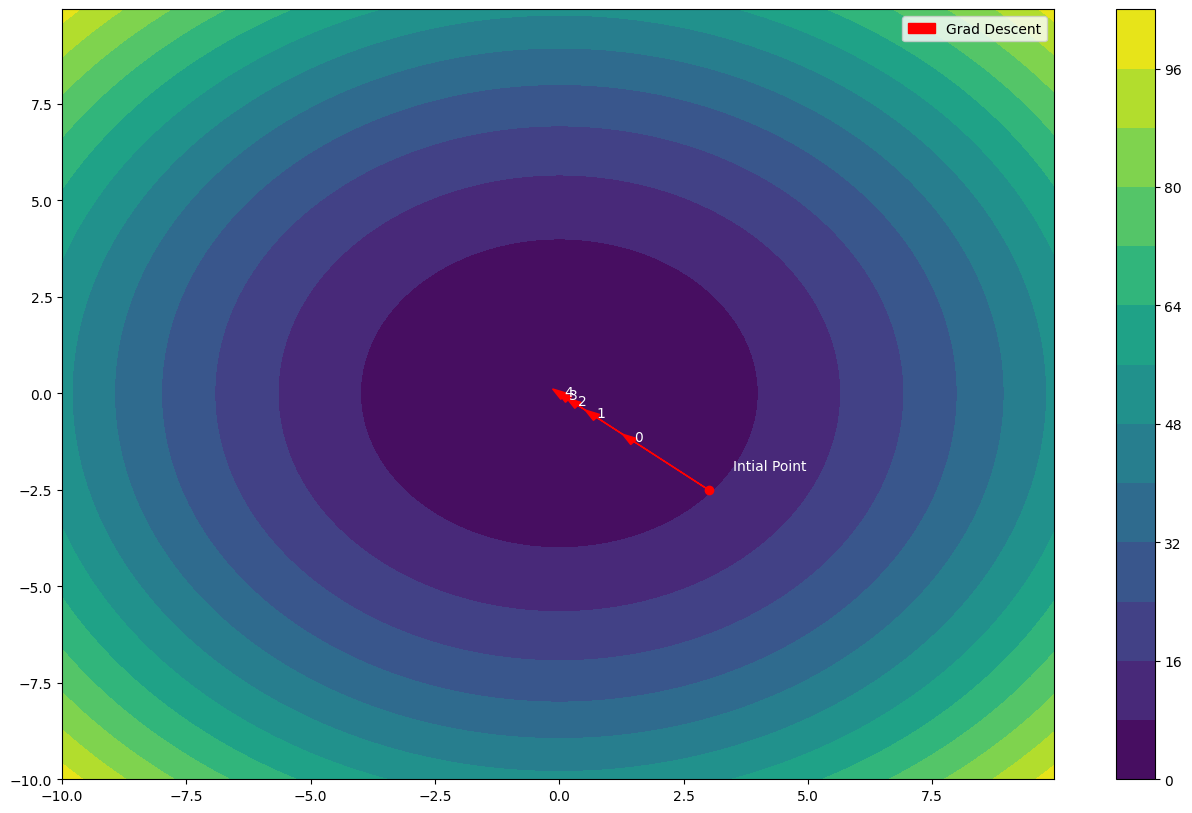

In [15]:
simple = QuadFunc(1, 1, 0, 0, 0)
init = torch.tensor([3.0,-2.5])
regGD = GradientDescent(0.5,0,0)
steps = 5
path = runOptim(init,regGD,simple,steps)
showPath(simple,init,[path],['Grad Descent'],['r'], 15)

Unfortunately, in deep learning we tend to not optimize such simple convex functions. Let's see what happens if we apply gradient descent to non-convex functions. Here is an example: $f(x,y) = x^2 - y^2$. Check that the path of gradient descent is very much dependent on how we choose the initialization.

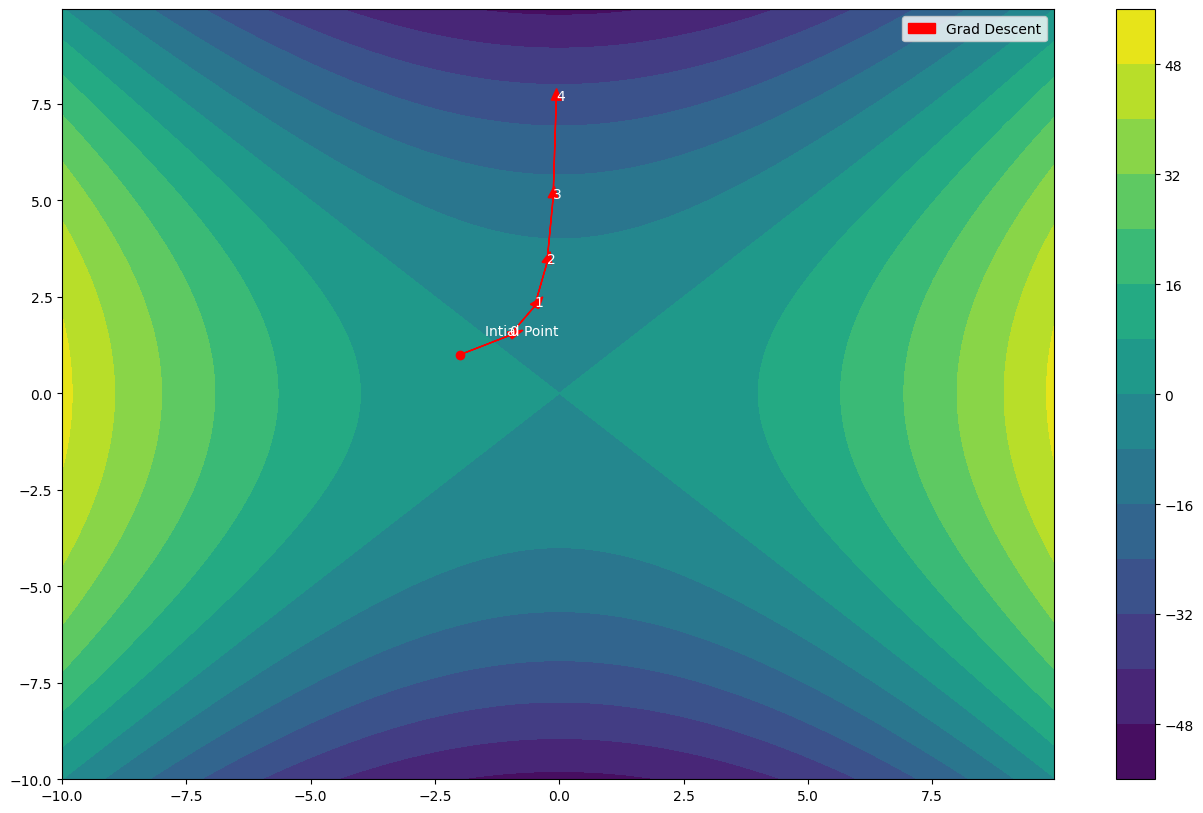

In [16]:
saddle = QuadFunc(1, -1, 0, 0, 0)
init = torch.tensor([-2.0,1.0]) # try (-2, 1) as well
regGD = GradientDescent(0.5,0,0)
steps = 5
path = runOptim(init,regGD,saddle,steps)
showPath(saddle,init,[path],['Grad Descent'],['r'], 15)

In fact, there is a more insiduous issue with gradient descent. Let's go back to the convex case (where everything is supposed to work). Choose a parabolic function where the level set contours are skewed ellipses: $$f(x,y) = x^2 + y^2 - 0.8 xy + x + y.$$
In such cases, gradient descent (which just follows the locally steepest direction) tends to oscillate quite a bit.

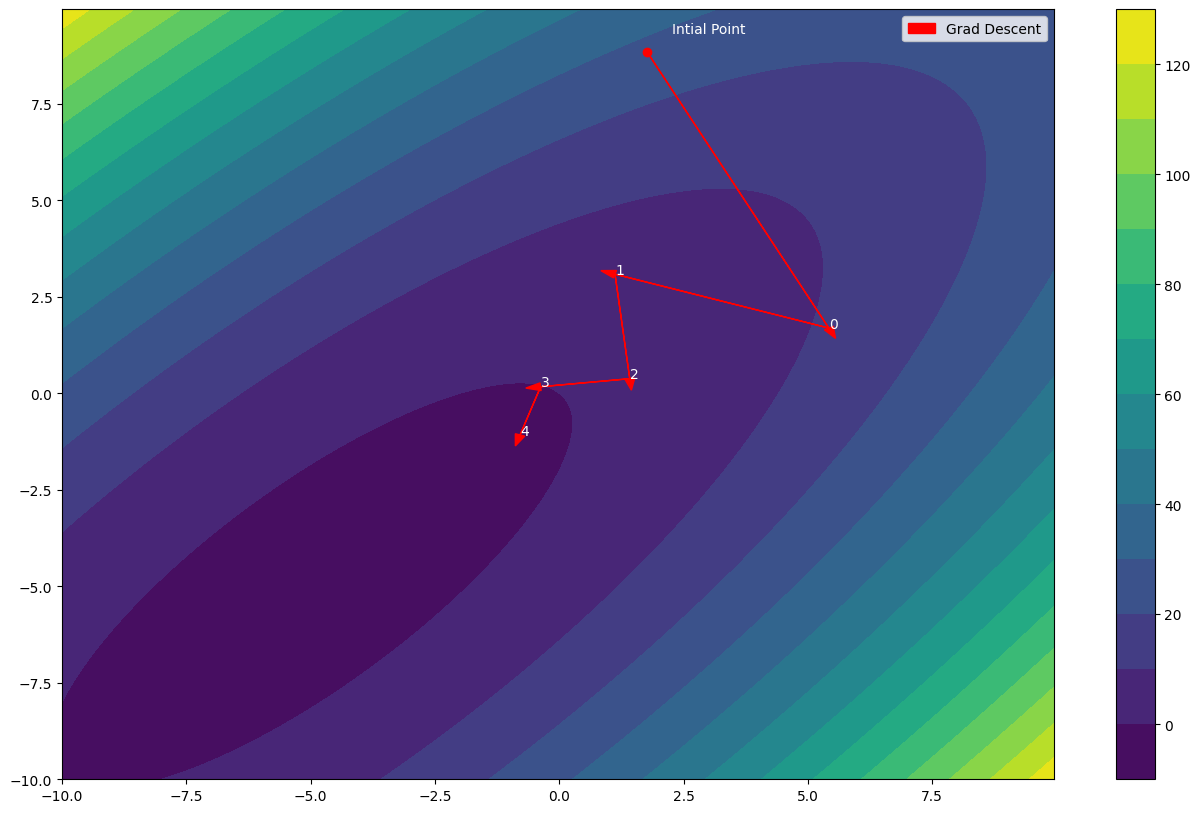

In [18]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 5
regGD = GradientDescent(1.2,0,0)
path = runOptim(init,regGD,ell,steps)
showPath(ell,init,[path],['Grad Descent'],['r'], 15)

## Gradient Descent Takeaways
- Depends upon initialization
- Follows direction of steepest descent

# Newton's method

One way to fix this is via Newton's method (which scales different gradient directions according to the second derivative, or the Hessian). This has the effect of "unskewing" the loss surface, making it look more like the parabola, and therefore enables easier optimization.

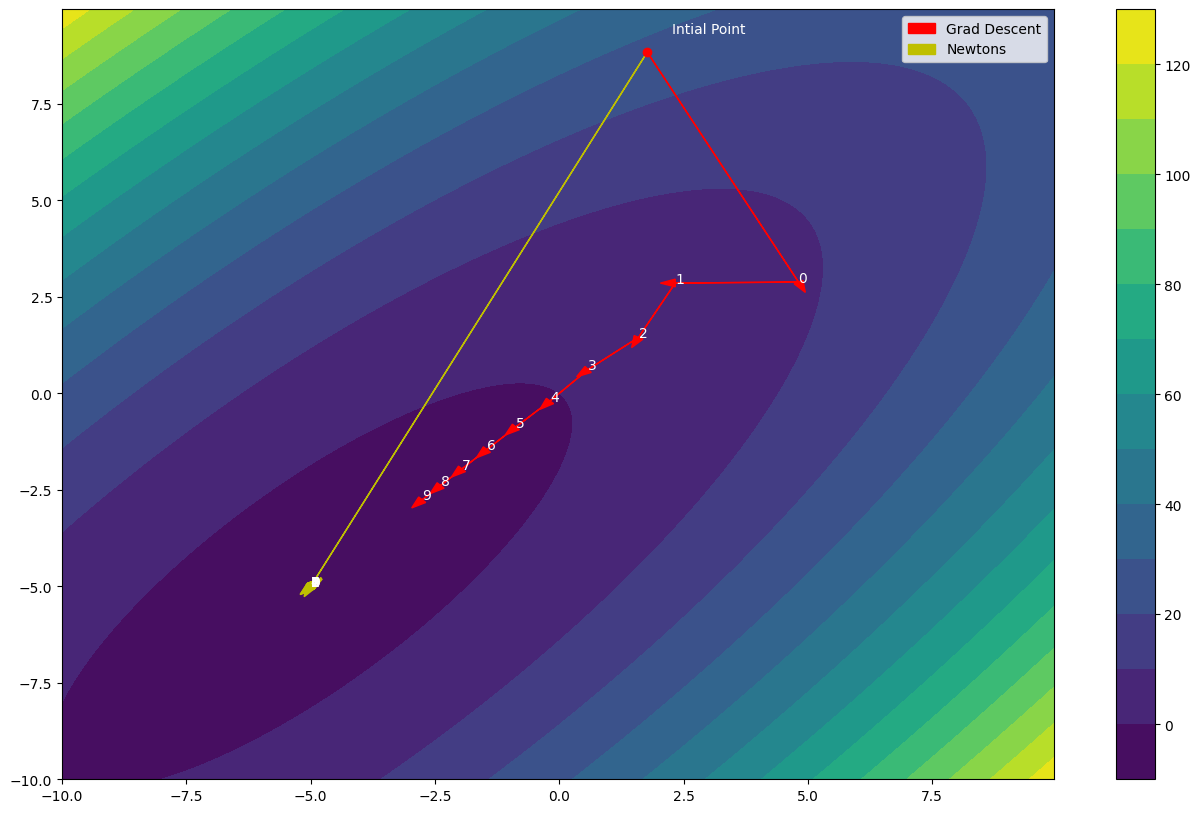

In [19]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 10
lr = 1
regGD = GradientDescent(lr,0,0)
newGD = Newtons(lr)
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,newGD,ell,steps)

showPath(ell,init,[path1,path2],['Grad Descent','Newtons'],['r','y'], 15)

Unfortunately, Newton's method is difficult to use in deep learning since Hessians are very difficult to compute if the number of parameters become large. Also, somewhat curiously, Newton's method tends to get attracted to saddle points. Let's revisit the saddle example.

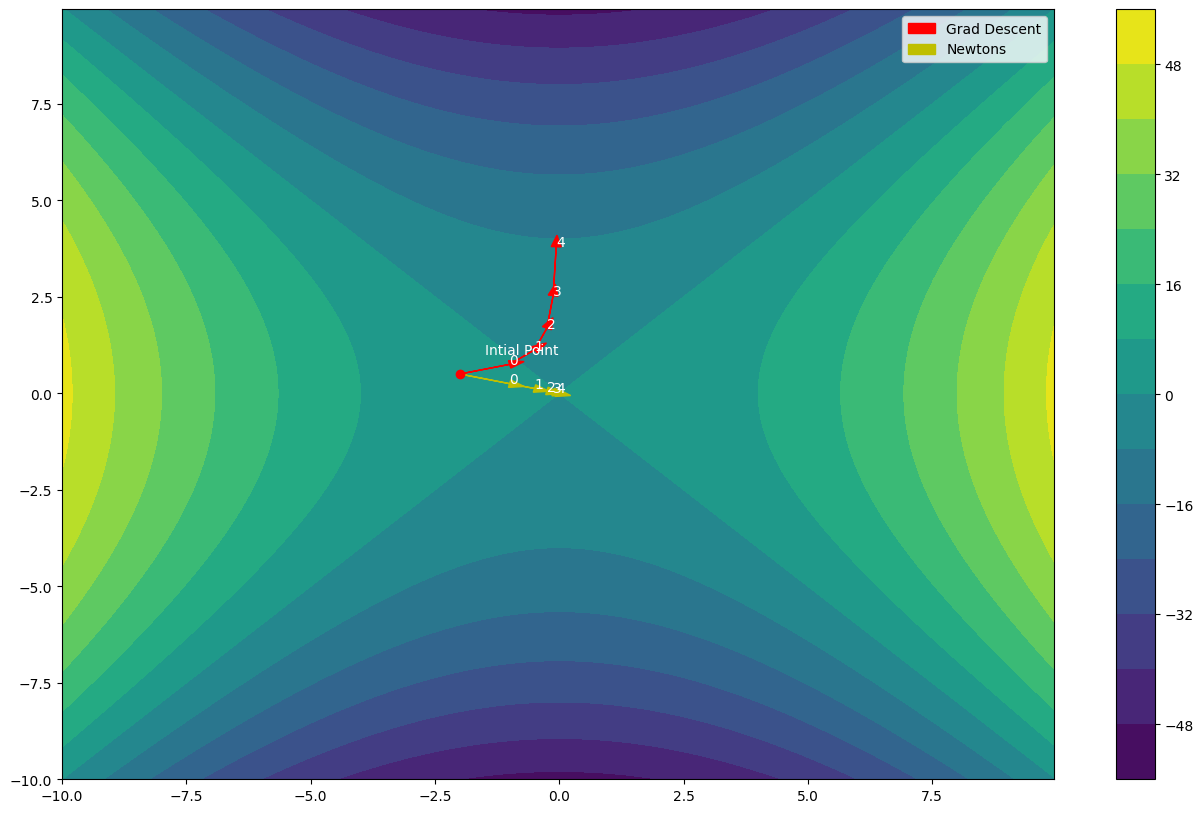

In [20]:
saddle = QuadFunc(a=1.0, b=-1.0, c=0.0, d=0.0, e=0.0)
init = torch.tensor([-2.0,0.5])
regGD = GradientDescent(lr=0.5, b1=0, b2=0)
steps = 5
newGD = Newtons(0.5)
path1 = runOptim(init,regGD,saddle,steps)
path2 = runOptim(init,newGD,saddle,steps)
showPath(saddle,init,[path1,path2],['Grad Descent','Newtons'],['r','y'], 15)

## Newton's Method takeaways
- Calculate second order derivatives is hard with many parameters
- Attracted to Saddle points

# Momentum

Momentum is a way to simulate the effects of Newton's method without looking at second order information. It adds a "damping" effect on the oscillations (so that the trajectories are typically smoother than standard GD). Let's see its effects in the ellipse example.

Somewhat surprisingly, the landscape issue can be resolved by adding a little bit of *memory* to the gradient dynamics as follows:

$
\begin{aligned}
w_{t+1} &= w_t - \eta v_t \\
v_t &= \beta g_t + (1 - \beta) V_{t-1} \\
\end{aligned}
$

As we saw in class now we have an intermediate variable $v_t$ that keeps a "memory" of the previous gradients. See the class [notes](https://gussand.github.io/dl-notes/notes/lecture03/#momentum) for more info.

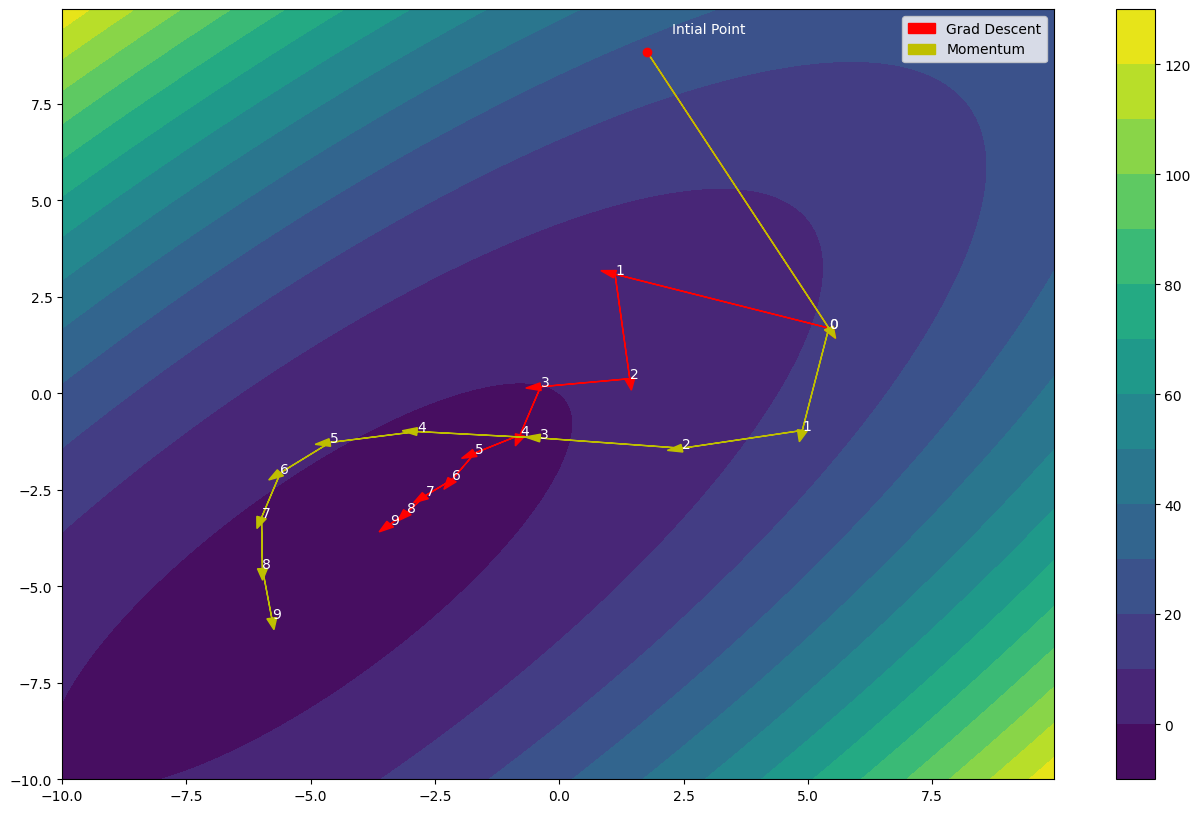

In [22]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 10
lr = 1.2
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
showPath(ell,init,[path1,path2],['Grad Descent','Momentum'],['r','y'], 15)

Given our value of $b_1$ above of $0.9$, we can "unroll" $v_t$

$v_t \leftarrow \beta g_t + 0.9 \beta g_{t-1} + 0.81 \beta g_{t-2} + 0.73\beta g_{t-3} + \cdots$

So our $v_t$ term places less importance on gradients calculated many timesteps ago and places more importance on recently computed gradients.

## Momemtum Takeaways
- Smoother Trajectory
- Choice of learning rate still matters

# ADAM

As we can see, momentum speeds up gradient descent but there's still the issue of tuning the learning rate property.

ADAM takes care of this by automatically tuning the learning rate ("adaptive scheduling").

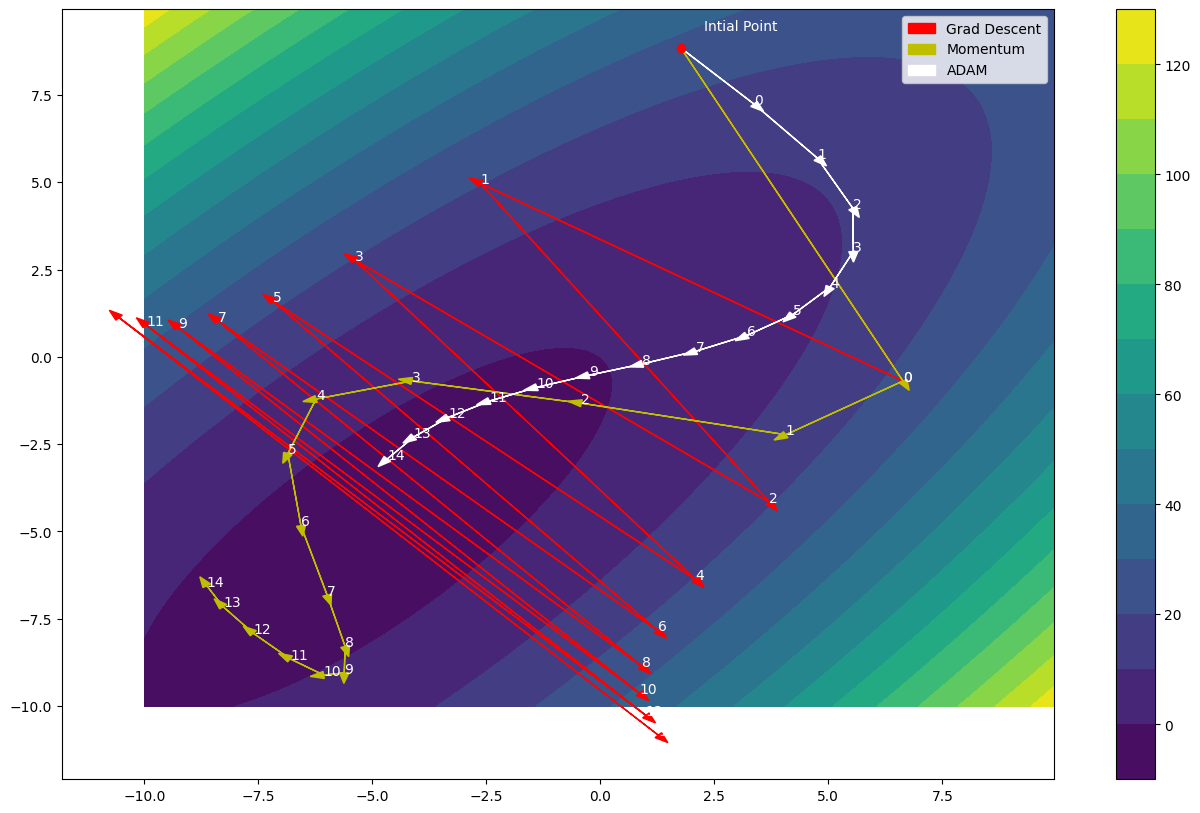

In [23]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 15
lr = 1.6
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
adamGD = GradientDescent(lr,0.9,0.999)
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
path3 = runOptim(init,adamGD,ell,steps)
showPath(ell,init,[path1,path2,path3],['Grad Descent','Momentum','ADAM'],['r','y','w'], 15)

That's it! Feel free to play around with various parameters -- different optimizers, different learning rates, damping factors, etc.

Onto the big question: which optimizer should be used?

Unfortunately there is no clear answer. The choice of "best" optimizer seems to be model-dependent. A general couple of thumb rules:
* For vision applications involving ResNets, SGD + momentum seems to be sufficient.
* for NLP applications and transformer architectures, ADAM seems to work really well.

In practice, it may be useful to play around with different optimizers and perform some basic hyperparameter tuning depending on your specific problem.